<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter7/sarcasm_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-04-19 13:47:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.06s   

2020-04-19 13:47:38 (90.2 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
# Download Glove -- project at https://github.com/stanfordnlp/GloVe
# I will use the https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.twitter.27B.25d.zip \
    -O /tmp/glove.zip

--2020-04-19 13:47:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.twitter.27B.25d.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112372936 (107M) [application/zip]
Saving to: ‘/tmp/glove.zip’

/tmp/glove.zip      100%[===================>] 107.17M   121MB/s    in 0.9s    

2020-04-19 13:47:43 (121 MB/s) - ‘/tmp/glove.zip’ saved [112372936/112372936]



In [0]:
# Unzip Glove Embeddings
import os
import zipfile

local_zip = '/tmp/glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove')
zip_ref.close()

In [0]:
glove_embeddings = dict()
f = open('/tmp/glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()


In [8]:
print('Loaded %s word vectors.' % len(glove_embeddings))

Loaded 1193514 word vectors.


In [0]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [0]:
vocab_size = 13000
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [71]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print(len(word_index))
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

24291


In [0]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)



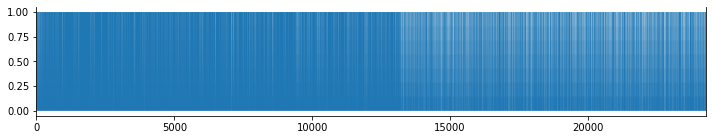

In [91]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)


[0.9165946235231156]


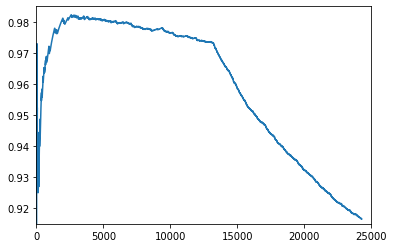

In [68]:
import matplotlib.pyplot as plt
plt.plot(cumulative_x, cumulative_y)
plt.axis([0, 25000, .915, .985])
print(cumulative_y[-1:])

In [0]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [73]:
print(embedding_matrix[2])
print(tokenizer.word_index)

[-0.177       0.43200001  0.21391    -0.29515001  0.47343999 -0.38012999
  1.60179996  0.56238002  0.40478    -0.57094002  0.34154001  0.40245
 -5.07679987 -0.1568     -0.27046999 -0.71336001  0.50856    -0.25975999
 -0.47931999  0.60913002 -1.00300002 -1.02250004 -0.099247   -0.58947998
 -0.42467999]
{'<OOV>': 1, 'new': 2, 'trump': 3, 'man': 4, 'not': 5, 'just': 6, 'will': 7, 'one': 8, 'year': 9, 'report': 10, 'area': 11, 'donald': 12, 'day': 13, 'u': 14, 's': 15, 'can': 16, 'says': 17, 'woman': 18, 'first': 19, 'time': 20, 'like': 21, 'no': 22, 'get': 23, 'old': 24, 'trumps': 25, 'off': 26, 'now': 27, 'life': 28, 'obama': 29, 'people': 30, 'house': 31, 'women': 32, 'white': 33, 'back': 34, 'still': 35, 'make': 36, 'clinton': 37, '5': 38, 'world': 39, 'americans': 40, 'years': 41, 'way': 42, 'family': 43, 'black': 44, 'study': 45, 'gop': 46, 'best': 47, 'bill': 48, 'american': 49, 'school': 50, 'police': 51, 'watch': 52, '3': 53, 'show': 54, 'really': 55, 'president': 56, 'home': 57, 

In [0]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [80]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 25)          325000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 50)          10200     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 351,649
Trainable params: 26,649
Non-trainable params: 325,000
_________________________________________________________________


In [81]:
num_epochs = 150
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/150
719/719 - 14s - loss: 0.6868 - accuracy: 0.5599 - val_loss: 0.6823 - val_accuracy: 0.5694
Epoch 2/150
719/719 - 13s - loss: 0.6800 - accuracy: 0.5615 - val_loss: 0.6745 - val_accuracy: 0.5727
Epoch 3/150
719/719 - 12s - loss: 0.6707 - accuracy: 0.5789 - val_loss: 0.6655 - val_accuracy: 0.5948
Epoch 4/150
719/719 - 12s - loss: 0.6601 - accuracy: 0.6135 - val_loss: 0.6552 - val_accuracy: 0.6236
Epoch 5/150
719/719 - 12s - loss: 0.6482 - accuracy: 0.6385 - val_loss: 0.6435 - val_accuracy: 0.6425
Epoch 6/150
719/719 - 12s - loss: 0.6358 - accuracy: 0.6548 - val_loss: 0.6325 - val_accuracy: 0.6562
Epoch 7/150
719/719 - 12s - loss: 0.6249 - accuracy: 0.6657 - val_loss: 0.6233 - val_accuracy: 0.6622
Epoch 8/150
719/719 - 12s - loss: 0.6163 - accuracy: 0.6716 - val_loss: 0.6166 - val_accuracy: 0.6708
Epoch 9/150
719/719 - 12s - loss: 0.6100 - accuracy: 0.6752 - val_loss: 0.6110 - val_accuracy: 0.6746
Epoch 10/150
719/719 - 13s - loss: 0.6049 - accuracy: 0.6790 - val_loss: 0.6068 - 

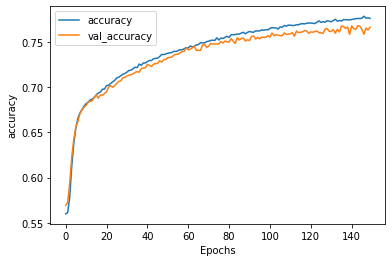

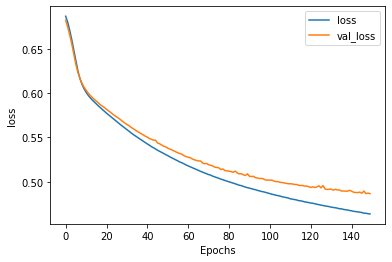

In [82]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [92]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting fear sons web series closest thing will grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting fear sons web series closest thing will grandchild 
1


In [93]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(13000, 25)


In [94]:
print(reverse_word_index[2])
print(weights[2])

new
[-0.177     0.432     0.21391  -0.29515   0.47344  -0.38013   1.6018
  0.56238   0.40478  -0.57094   0.34154   0.40245  -5.0768   -0.1568
 -0.27047  -0.71336   0.50856  -0.25976  -0.47932   0.60913  -1.003
 -1.0225   -0.099247 -0.58948  -0.42468 ]


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

#test_sentences = ["granny starting to fear spiders in the garden might be real", 
# "game of thrones season finale showing this sunday night", 
# "TensorFlow book will be a best seller"]
sequences = tokenizer.texts_to_sequences(test_sentences)
#print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#print(padded)

predictions = model.predict(padded)
#print(predictions[:, max_length-1])

In [102]:
print(predictions)

[[0.8170955 ]
 [0.08711044]
 [0.61809343]
 [0.8015281 ]]
